# Project 2B

### Import thu vien

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string
from transformers import PreTrainedModel
import nltk
import pandas as pd
#from tqdm import tqdm3
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import transformers
from sentence_transformers import SentenceTransformer
import torch
from peft import LoraConfig, get_peft_model
from transformers import (
   AutoModelForSequenceClassification,
   AutoTokenizer,
   BitsAndBytesConfig,
   TrainingArguments,
   Trainer)
from sklearn.model_selection import train_test_split

c:\Users\Admin\OneDrive\Desktop\test\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
device

device(type='cuda')

### read data and info data

In [4]:
classifirer = pd.read_json(path_or_buf=r"D:\22DKHA1\social\Final\2A\Dataset\readme_data.jsonl", lines=True)

In [17]:
classifirer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57383 entries, 0 to 57382
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   repo_id    57383 non-null  object        
 1   full_name  57383 non-null  object        
 2   readme     57383 non-null  object        
 3   timestamp  57383 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB


In [5]:
label = pd.read_csv(r"D:\22DKHA1\social\Final\2A\Dataset\github_repos_classified.csv")

In [6]:
label = label[['repo_id','category']]

In [7]:
final_dataset = pd.merge(classifirer,label,on='repo_id')

In [8]:
final_dataset = final_dataset[['repo_id','readme','category']]

In [22]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57413 entries, 0 to 57412
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   repo_id   57413 non-null  object
 1   readme    57413 non-null  object
 2   category  57413 non-null  object
dtypes: object(3)
memory usage: 1.3+ MB


In [9]:
final_dataset.duplicated().sum()

45

In [10]:
final_dataset.drop_duplicates(subset=['repo_id'],inplace=True)
final_dataset.reset_index(drop=True)

,repo_id,readme,category
0,MDEwOlJlcG9zaXRvcnkxNTUyMjA2NDE=,<!---\nCopyright 2020 The HuggingFace Team. Al...,AI_DataScience
1,MDEwOlJlcG9zaXRvcnk2NTYwMDk3NQ==,![PyTorch Logo](https://github.com/pytorch/pyt...,AI_DataScience
2,R_kgDOJ-2MVA,# Build a Large Language Model (From Scratch)\...,AI_DataScience
3,MDEwOlJlcG9zaXRvcnk3MTU4MzYwMg==,<!-- omit in toc -->\n# Computer Science cours...,AI_DataScience
4,MDEwOlJlcG9zaXRvcnkxMTU0Nzg4MjA=,[![Logo](/logo.png)](http://awesome-scalabilit...,AI_DataScience
...,...,...,...
57363,R_kgDOHwL4GA,# Monitoring ML\n\nLearn how to monitor ML sys...,AI_DataScience
57364,MDEwOlJlcG9zaXRvcnkxNjM1OTEyODk=,# CheckInstalledWindowsUpdates\nScript intende...,SoftwareEngTools
57365,MDEwOlJlcG9zaXRvcnkxOTQ3OTYxNzM=,"<p align=""center""><a href=""https://github.com/...",SoftwareEngTools
57366,MDEwOlJlcG9zaXRvcnkxNzMyNTMyNzE=,# ![](https://github.com/sourceplusplus/source...,SoftwareEngTools


In [25]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57368 entries, 0 to 57412
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   repo_id   57368 non-null  object
 1   readme    57368 non-null  object
 2   category  57368 non-null  object
dtypes: object(3)
memory usage: 1.8+ MB


### Preprocess

In [12]:
class BertTextPreprocessor:
    """ Preprocess using regex and remove unecessary words"""
    def __init__(self, remove_code=True, remove_urls=True, lowercase=True):
        self.remove_code = remove_code
        self.remove_urls = remove_urls
        self.lowercase = lowercase
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

        # Add common programming keywords to stop words
        self.programming_stop_words = {
            'install', 'installation', 'usage', 'example', 'documentation',
            'license', 'contributing', 'readme', 'github', 'git','href','src','link',
            'fire','logo','bottom','language','icon','title','platform','source','like',
            'pain','convenience','summary','release','default', 'created','last', 'mark',
            'code','updated','loading','file','unless','project','title','effortlessly',
            'csinternship','found','first','favorite','favourite','app','new','awesome',
            'welcome','getting','started','trying','please','need', 'believe','feel',
            'instead','let','think','use', 'thank','everyone','anyone', 'edit','run',
            'without','see','simple', 'work','additional','information' ,'regarding',
            'copyright', 'ownership' ,'asf','needed','system','building','helped','fix',
            'discussion','fixed','install','useful','come','several','consist','of','follow',
            'want','get','unique','way','changing','making','might','can','different','know',
            'used','one','fastest','fast','also','various','could','try','noted','note',
            'contribute','to','known','professional','community','team','usually','resarch',
            'paper','download','often','rarely','never','png','conversation','karate','alt',
            'friendly', 'icon','heavy','communication', 'resource','adjust','using','pre','built',
            'optional','option','platform','bug','fix','magical','commit','main','build','version',
            'repository','img','test','issue','create','tool','support','command','add'
        }
        self.stop_words.update(self.programming_stop_words)

    def clean_text(self, text):
        """
        Clean and normalize text
        """
        if not isinstance(text, str):
            return ""

        # Remove URLs
        if self.remove_urls:
            text = re.sub(r'http\S+|www\S+|https\S+', '', text)

        # Remove code blocks (markdown)
        if self.remove_code:
            text = re.sub(r'```[\s\S]*?```', '', text)  # Code blocks
            text = re.sub(r'`[^`]*`', '', text)  # Inline code

        # Remove markdown syntax
        text = re.sub(r'#+\s', '', text)  # Headers
        text = re.sub(r'\*\*([^*]+)\*\*', r'\1', text)  # Bold
        text = re.sub(r'\*([^*]+)\*', r'\1', text)  # Italic
        text = re.sub(r'```math([^```]+)```KATEX_INLINE_OPEN[^KATEX_INLINE_CLOSE]+KATEX_INLINE_CLOSE', r'\1', text)  # Links

        # Remove special characters but keep spaces
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)
        # Convert to lowercase
        if self.lowercase:
            text = text.lower()

        # Remove extra whitespace
        text = ' '.join(text.split())

        return text

    def tokenize_and_lemmatize(self, text):
        """
        Tokenize and lemmatize text
        """
        tokens = word_tokenize(text)

    # Remove stop words
        tokens = [token for token in tokens if token.lower() not in self.stop_words and len(token) > 2]

        return ' '.join(tokens)

    def preprocess(self, text):
        """
        Full preprocessing pipeline
        """
        text = self.clean_text(text)
        text = self.tokenize_and_lemmatize(text)
        return text

In [15]:
preprocessor_bert = BertTextPreprocessor()

In [18]:
final_dataset['cleanedText'] = final_dataset['readme'].apply(preprocessor_bert.preprocess)

In [32]:
final_dataset

,repo_id,readme,category,cleanedText
0,MDEwOlJlcG9zaXRvcnkxNTUyMjA2NDE=,<!---\nCopyright 2020 The HuggingFace Team. Al...,AI_DataScience,huggingface rights reserved licensed apache ma...
1,MDEwOlJlcG9zaXRvcnk2NTYwMDk3NQ==,![PyTorch Logo](https://github.com/pytorch/pyt...,AI_DataScience,pytorch pytorch python package provides two hi...
2,R_kgDOJ-2MVA,# Build a Large Language Model (From Scratch)\...,AI_DataScience,large model scratch contains developing pretra...
3,MDEwOlJlcG9zaXRvcnk3MTU4MzYwMg==,<!-- omit in toc -->\n# Computer Science cours...,AI_DataScience,omit toc computer science courses video lectur...
4,MDEwOlJlcG9zaXRvcnkxMTU0Nzg4MjA=,[![Logo](/logo.png)](http://awesome-scalabilit...,AI_DataScience,organized reading list illustrating patterns s...
...,...,...,...,...
57408,R_kgDOHwL4GA,# Monitoring ML\n\nLearn how to monitor ML sys...,AI_DataScience,monitoring learn monitor systems identify addr...
57409,MDEwOlJlcG9zaXRvcnkxNjM1OTEyODk=,# CheckInstalledWindowsUpdates\nScript intende...,SoftwareEngTools,checkinstalledwindowsupdates script intended a...
57410,MDEwOlJlcG9zaXRvcnkxOTQ3OTYxNzM=,"<p align=""center""><a href=""https://github.com/...",SoftwareEngTools,align center frontend public svg grafolean wid...
57411,MDEwOlJlcG9zaXRvcnkxNzMyNTMyNzE=,# ![](https://github.com/sourceplusplus/source...,SoftwareEngTools,plugin description contains jetbrains ide plug...


In [19]:
final_dataset['category']= final_dataset['category'].astype('category').cat.codes

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Number of classes in dataset')

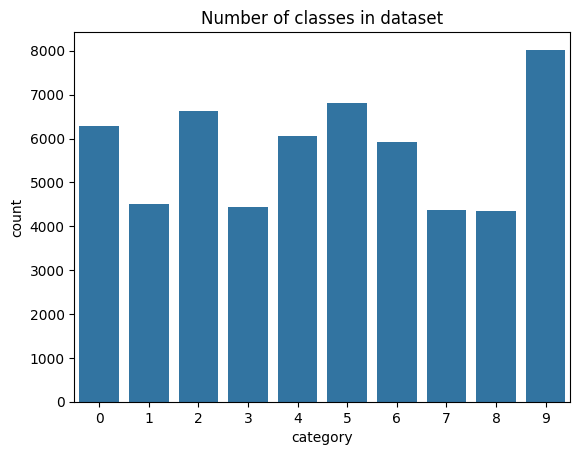

In [34]:
sns.countplot(x='category',data=final_dataset)
plt.title('Number of classes in dataset')

### Split train test

In [21]:
train_set, test_set = train_test_split(final_dataset,random_state=42,test_size=0.2,stratify=final_dataset['category'])
print(train_set.shape, test_set.shape)

(45894, 4) (11474, 4)


C:\Users\84941\AppData\Local\Temp\ipykernel_10776\2523633153.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='category', data=train_set, palette='viridis')
c:\Users\84941\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\84941\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Use

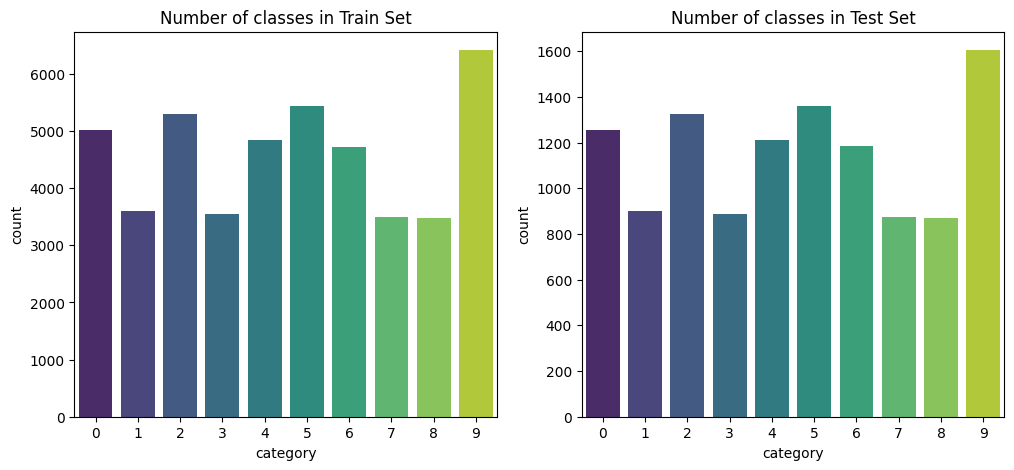

In [4]:
# vẽ bar chart số lượng mẫu trong từng lớp của tập train và test bằng read csv train và test
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
train_set = pd.read_csv(r"D:\22DKHA1\social\train_set.csv")
test_set = pd.read_csv(r"D:\22DKHA1\social\test_set.csv")

# thêm màu sắc vào bar chart
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
sns.countplot(x='category', data=train_set, palette='viridis')
plt.title('Number of classes in Train Set')
plt.subplot(1, 2, 2)
sns.countplot(x='category', data=test_set, palette='viridis')
plt.title('Number of classes in Test Set')
plt.show()

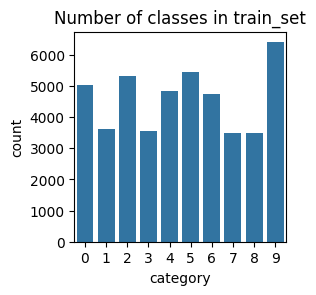

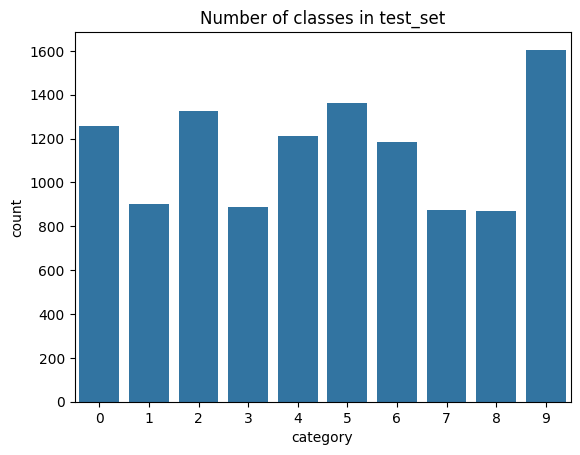

In [22]:
plt.figure(figsize=(6, 6))
plt.subplot(2, 2, 2)
sns.countplot(x='category',data=train_set)
plt.title('Number of classes in train_set')
plt.show()
sns.countplot(x='category',data=test_set)
plt.title('Number of classes in test_set')
plt.show()

Text(0.5, 1.0, 'Number of classes in test_set')

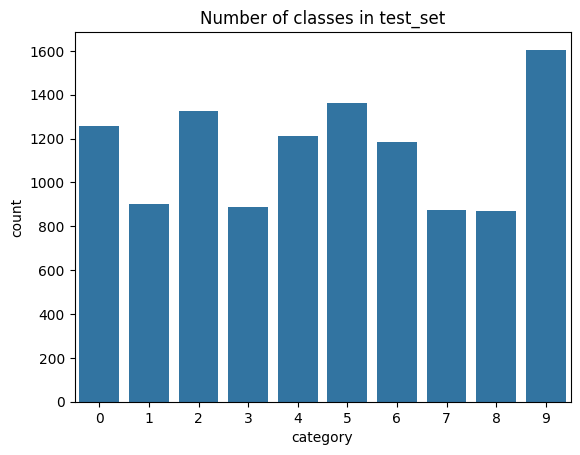

In [37]:
sns.countplot(x='category',data=test_set)
plt.title('Number of classes in test_set')

In [38]:
train_set = train_set[['cleanedText','category']]
test_set = test_set[['cleanedText','category']]

In [39]:
## Optional: save both train and test set
train_set.to_csv('train_set.csv',index=False)
test_set.to_csv('test_set.csv',index=False)

### embedding

In [1]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import pandas as pd

In [16]:
train_set = pd.read_csv(r"C:\Users\Admin\OneDrive\Desktop\test\train_set.csv")
test_set = pd.read_csv(r'C:\Users\Admin\OneDrive\Desktop\test\test_set.csv')

In [15]:
train_set.shape

(45894, 2)

In [17]:
test_set.shape

(11474, 2)

In [10]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [11]:
train_list = train_set['cleanedText'].tolist()
test_list = test_set['cleanedText'].tolist()
train_list = [str(text) for text in train_list]
test_list = [str(text) for text in test_list]

In [21]:
train_encoded = model.encode(train_list, show_progress_bar=True, convert_to_numpy=True,
                          device=device,normalize_embeddings=True)
test_encoded = model.encode(test_list, show_progress_bar=True, convert_to_numpy=True,
                          device=device,normalize_embeddings=True)

Batches: 100%|██████████| 359/359 [00:23<00:00, 15.56it/s]


In [47]:
## use for ML and non transformer
X = train_encoded
y = train_set['category']
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=42,stratify=y)

## classic ML

### Logistic

In [48]:
model_lr = LogisticRegression(class_weight='balanced',max_iter=1000)
model_lr.fit(x_train,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [49]:
y_pred = model_lr.predict(x_test)

report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

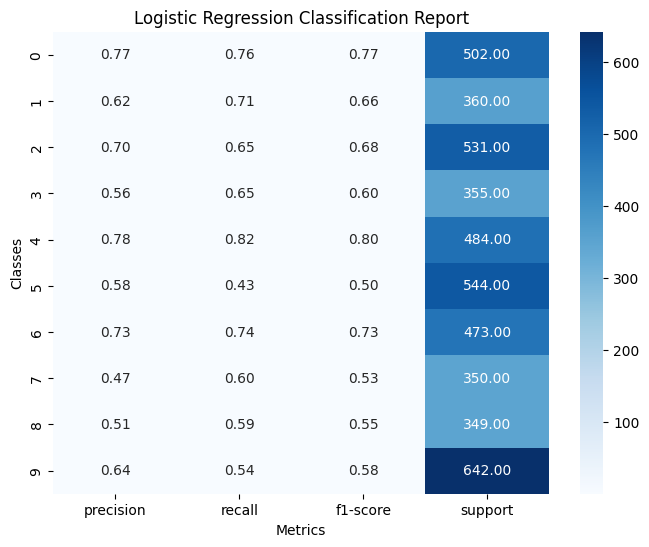

In [50]:
class_report_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'])

plt.figure(figsize=(8, 6))
sns.heatmap(class_report_df, annot=True, cmap='Blues', fmt='.2f')

plt.title('Logistic Regression Classification Report')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.show()

### RF

In [51]:
model_rf = RandomForestClassifier(class_weight='balanced')
model_rf.fit(x_train,y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [52]:
y_pred = model_rf.predict(x_test)

report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

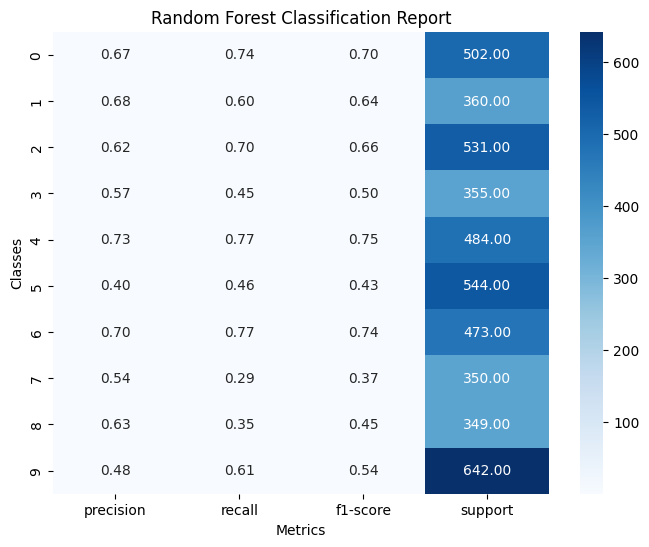

In [53]:
class_report_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'])

plt.figure(figsize=(8, 6))
sns.heatmap(class_report_df, annot=True, cmap='Blues', fmt='.2f')

plt.title('Random Forest Classification Report')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.show()

### SVC

In [54]:
model_svc = SVC(class_weight='balanced',kernel='linear')
model_svc.fit(x_train,y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,False


In [55]:
y_pred = model_svc.predict(x_test)

report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

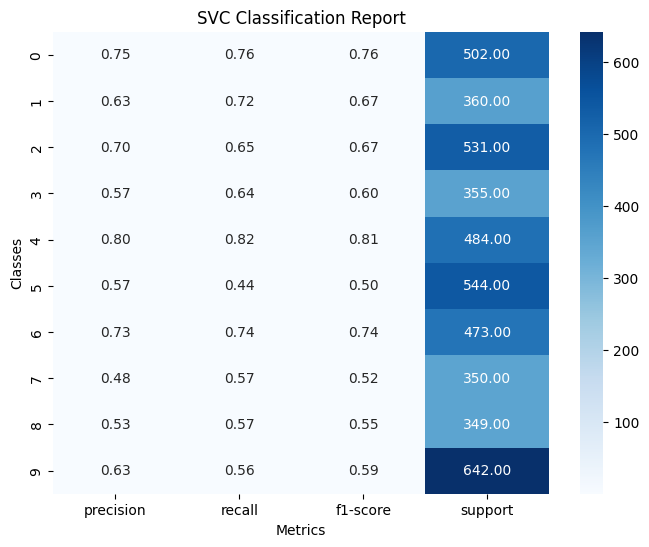

In [56]:
class_report_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'])

plt.figure(figsize=(8, 6))
sns.heatmap(class_report_df, annot=True, cmap='Blues', fmt='.2f')

plt.title('SVC Classification Report')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.show()

### KNN

In [ ]:
model_knn = KNeighborsClassifier(class_weight='balanced')
model_knn.fit(x_train,y_train)

In [58]:
y_pred = model_knn.predict(x_test)

report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

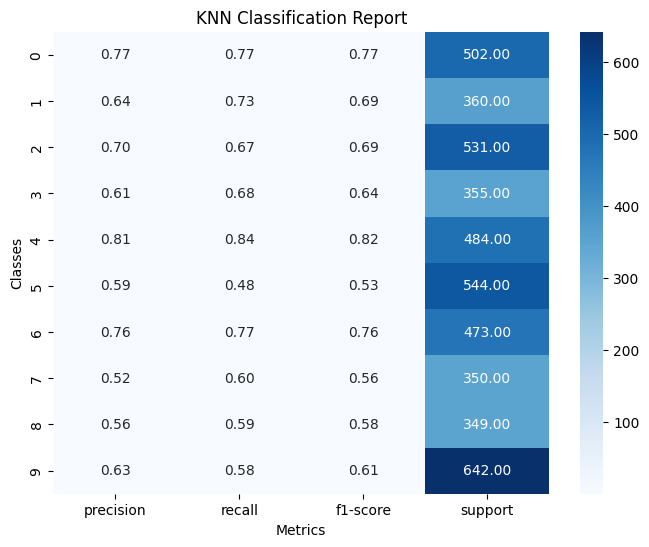

In [59]:
class_report_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'])

plt.figure(figsize=(8, 6))
sns.heatmap(class_report_df, annot=True, cmap='Blues', fmt='.2f')

plt.title('KNN Classification Report')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.show()

## Transformer using peft techniques

#### Dataset for transformer

In [ ]:
model_name = "mistralai/Mistral-7B-v0.1" # Example open-source model
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

In [13]:
train_set.dropna( inplace=True)

In [14]:
tokenized_train_data = tokenizer(
    train_list, # Pass the clean list here
    padding="max_length",
    truncation=True,
    return_tensors="pt",
    max_length=512
)
tokenized_test_data = tokenizer(
    test_list, # Pass the clean list here
    padding="max_length",
    truncation=True,
    return_tensors="pt",
    max_length=512
)

In [15]:
import datasets
from datasets import Dataset, DatasetDict

In [16]:
class TextEncodingDataset(Dataset):
    def __init__(self, tokenized_data, labels):
        # This now expects 'labels' to be a NumPy array or list
        self.tokenized_data = tokenized_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # This will now work perfectly because self.labels[idx] is an integer
        item = {key: torch.tensor(val[idx]) for key, val in self.tokenized_data.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

In [17]:
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding

In [18]:
train_dataset = TextEncodingDataset(tokenized_train_data, train_set['category'].to_numpy())
test_dataset = TextEncodingDataset(tokenized_test_data, test_set['category'].to_numpy())
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [19]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=256, # Small batch size for example
    collate_fn=data_collator # Use the collator here!
)

In [20]:
test_dataloader = DataLoader(
    test_dataset,
    batch_size=256, # Small batch size for example
    collate_fn=data_collator # Use the collator here!
)

#### initialize the model

In [ ]:
lora_config = LoraConfig(
    r=16, # Rank of the update matrices
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_CLS"
)

In [ ]:
quantization_config = BitsAndBytesConfig(load_in_4bit=True)

In [ ]:
path = (r'C:\Users\Administrator\Downloads\project\Mistral-7B-v0.1')
peft_model = AutoModelForSequenceClassification.from_pretrained(
    path,
    num_labels=10, # number of classes
    quantization_config=quantization_config,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)
peft_model = get_peft_model(peft_model, lora_config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
%cd C:/Users/Admin/OneDrive/Desktop/test
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=256,
    per_device_eval_batch_size=256,
    warmup_steps=100,                   # Number of steps for learning rate warmup
    weight_decay=0.01,
    # logging_dir="./logs",              # Directory for storing logs
    do_train=True,
    do_eval=True,
    logging_steps=10,
    eval_strategy = 'epoch',
    save_strategy="epoch",             # Save a checkpoint at the end of each epoch
    load_best_model_at_end=True,
    logging_strategy="epoch",
    fp16=True,
    dataloader_num_workers=5,
    remove_unused_columns=False,      # Load the best model after training is done
    gradient_accumulation_steps=7
)

C:\Users\Admin\OneDrive\Desktop\test


c:\Users\Admin\OneDrive\Desktop\test\.venv\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [23]:
import evaluate

In [24]:
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Use the new metric object to compute
    return accuracy_metric.compute(predictions=predictions, references=labels)

In [25]:
## rollback to this version if needed
print(np.__version__)

2.1.2


In [ ]:
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [ ]:
print(peft_model.device)

cuda:0


In [ ]:
trainer.train()

In [ ]:
trainer.save_pretrained(save_directory = 'C:\Users\Administrator\Desktop\project',safe_serialization = True)

### Visualize the output of transformer

In [ ]:
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
logits = predictions.predictions
y_pred = np.argmax(logits, axis=1)

# Apply softmax to logits to get probabilities
from scipy.special import softmax
y_score = softmax(logits, axis=1)

In [15]:
target_names = ["0", "1", "2", "3", "4","5", "6", "7", "8", "9"]

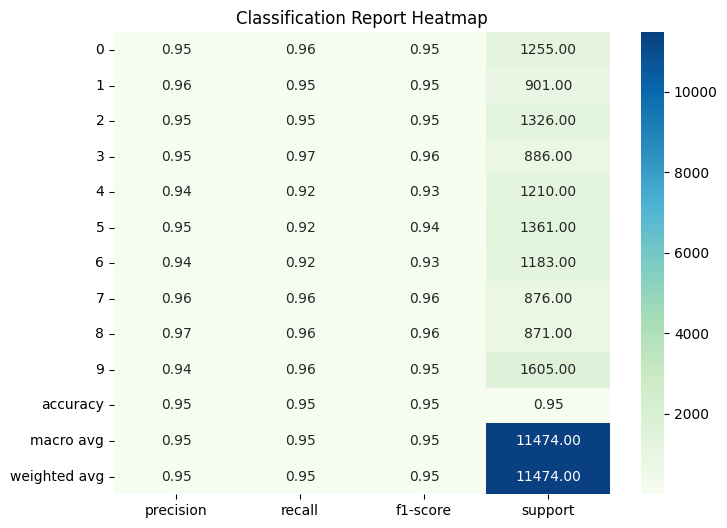

In [ ]:
report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)

# 2. Convert to a DataFrame and remove unnecessary rows
report_df = pd.DataFrame(report).transpose()
#report_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'])

# 3. Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df, annot=True, cmap='viridis', fmt='.2f')
plt.title('Classification Report Heatmap')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred, target_names=target_names))

                precision    recall  f1-score    support
            0        0.95      0.96      0.95       1255
            1        0.96      0.95      0.95        901
            2        0.95      0.95      0.95       1326
            3        0.95      0.97      0.96        886
            4        0.94      0.92      0.93       1210
            5        0.95      0.92      0.94       1361
            6        0.94      0.92      0.93       1183
            7        0.96      0.96      0.96        876
            8        0.97      0.96      0.96        871
            9        0.94      0.96      0.95       1605

     accuracy                            0.95      11474
    macro avg        0.95      0.95      0.95      11474
 weighted avg        0.95      0.95      0.95      11474
